In [19]:
# Python setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from torch import optim, cuda
import torch
from datetime import datetime
import pandas as pd

In [2]:
# Setting up paths
base_path = Path('./clean_data/').absolute()
raw_base_path = base_path / 'motorcycles'
raw_train_path = str(raw_base_path / 'train')
raw_val_path = str(raw_base_path / 'val')
raw_test_path = str(raw_base_path / 'test')
square_base_path = base_path / 'square_motorcycles'
square_train_path = str(square_base_path / 'train')
square_val_path = str(square_base_path / 'val')
square_test_path = str(square_base_path / 'test')

In [3]:


def get_model(num_classes):
    '''
    Creates a resnet-50 pretrained model and replaces the classifier with a new classifier
    '''
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_inputs = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_inputs, 256),
                                       nn.ReLU(),
                                       # Get rid of dropout. I will re-evaluate later
                                       #nn.Dropout(0.4),
                                       nn.Linear(256, num_classes),
                                       nn.LogSoftmax(dim=1))
    # Move to the GPU
    model = model.to('cuda')
    return model

In [4]:
def forward_pass(model, dataloader, criterion, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    '''
    total_loss = 0
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            loss = criterion(result, target)
            batch_loss = loss.item() * data.size(0)
            total_loss += batch_loss
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    mean_loss = total_loss / len(dataloader.dataset)
    return({'mean_loss': mean_loss})
        

In [10]:
def get_accuracy(model, dataloader, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    '''
    total_images = len(dataloader.dataset)
    correct_predictions = 0
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            _, predicted = torch.max(result.data, 1)
            # Get accurate images
            correct_predictions += (predicted == target).sum().item()
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    return correct_predictions / total_images

In [6]:
# See https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for hyperparameters
# hyper parameters are set to the research recommendations
def basic_train_model(data, dataloaders, epochs, clear_cuda_cache=True, name='basic model',
                      alpha=.001, beta1=0.9, beta2=0.999, epsilon=10e-8, weight_decay=0):
    '''
    Very-early training function. Not much here, but the basics to train the
    model and report loss and cuda memory
    data: A pytorch dataset with train and val data
    dataloader: A Pytorch dataloader with train and validation datasets
    clear_cuda_cache: Boolean telling us to clear the cuda cache when possible
    name: String with a name to give the model.
    '''
    start_time = datetime.now()
    results = []
    cuda_memory = []
    num_classes = len(data['train'].classes)

    model = get_model(num_classes)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2), 
                           eps=epsilon, weight_decay=weight_decay)

    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1}')
        train_loss = 0.0
        for data, targets in dataloaders['train']:
             #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            data = data.to('cuda')
            targets = targets.to('cuda')
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the gradients
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Get loss for the batch
            batch_loss = loss.item() * data.size(0)
            train_loss += batch_loss
            optimizer.step()
            #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the batch from cuda memory. It is no longer needed
            if clear_cuda_cache is True:
                data = None
                targets = None
                cuda.empty_cache()
        
        mean_train_loss = train_loss / len(dataloaders['train'].dataset)

        
        # Get validation loss
        validation_results = forward_pass(model, dataloaders['val'], criterion, clear_cuda_cache=clear_cuda_cache)
        # Get test accuracy
        test_accuracy = get_accuracy(model, dataloaders['test'])
        
        print(f'Train_loss: {mean_train_loss}, Val loss: {validation_results["mean_loss"]}, Test Accuracy: {test_accuracy}')
        results.append({
            'epoch': epoch + 1,
            'train_loss': mean_train_loss,
            'val_loss': validation_results['mean_loss'],
            'test_accuracy': test_accuracy})
        
    end_time = datetime.now()
    return {'model': model, 'name': name, 'results': results, 'cuda_memory': cuda_memory, 
            'run_time': end_time - start_time}

In [7]:

batch_size = 128

basic_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
basic_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = basic_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = basic_transforms['valid']),
    'test': datasets.ImageFolder(root=raw_val_path, transform = basic_transforms['valid'])
}

basic_dataloaders = {
    'train': DataLoader(basic_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(basic_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(basic_data['test'], batch_size=batch_size, shuffle=True),
    
}


complex_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
complex_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = complex_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = complex_transforms['valid']),
     'test': datasets.ImageFolder(root=raw_val_path, transform = complex_transforms['valid'])
}

complex_dataloaders = {
    'train': DataLoader(complex_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(complex_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(complex_data['test'], batch_size=batch_size, shuffle=True)
}



In [11]:
raw_results_clear_cache = basic_train_model(data=basic_data, dataloaders=basic_dataloaders, epochs=50, alpha=0.003,
                                            name='Basic images with basic transforms with clear', clear_cuda_cache=True)

#complex_results_clear_cache = basic_train_model(data=complex_data, dataloaders=complex_dataloaders, epochs=50, alpha=0.003,
#                                            name='Basic images with complex transforms with clear', clear_cuda_cache=True)

Epoch: 1
Train_loss: 6.005568485731266, Val loss: 5.898532177510046, Test Accuracy: 0.001455604075691412
Epoch: 2
Train_loss: 5.89909698377195, Val loss: 5.8989420957440375, Test Accuracy: 0.001455604075691412
Epoch: 3
Train_loss: 5.897452520611072, Val loss: 5.899466225153494, Test Accuracy: 0.001455604075691412
Epoch: 4
Train_loss: 5.896954308250636, Val loss: 5.900050899694406, Test Accuracy: 0.001455604075691412
Epoch: 5
Train_loss: 5.896485316892904, Val loss: 5.900623472149889, Test Accuracy: 0.001455604075691412
Epoch: 6
Train_loss: 5.895924657466972, Val loss: 5.9011680993103734, Test Accuracy: 0.001455604075691412
Epoch: 7
Train_loss: 5.895558754706414, Val loss: 5.901761434657779, Test Accuracy: 0.001455604075691412
Epoch: 8
Train_loss: 5.89508610677037, Val loss: 5.902333010405606, Test Accuracy: 0.001455604075691412
Epoch: 9
Train_loss: 5.894752823019834, Val loss: 5.902898572591368, Test Accuracy: 0.001455604075691412
Epoch: 10
Train_loss: 5.894302387386366, Val loss: 5.90

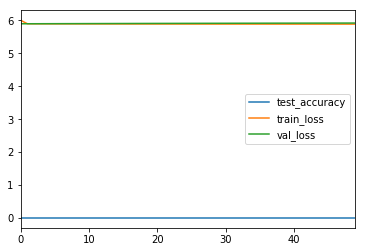

In [26]:
results = pd.DataFrame(raw_results_clear_cache['results'])
results.set_index('epoch')
results

In [20]:
results

,epoch,test_accuracy,train_loss,val_loss
0,1,0.001456,6.005568,5.898532
1,2,0.001456,5.899097,5.898942
2,3,0.001456,5.897453,5.899466
3,4,0.001456,5.896954,5.900051
4,5,0.001456,5.896485,5.900623
5,6,0.001456,5.895925,5.901168
6,7,0.001456,5.895559,5.901761
7,8,0.001456,5.895086,5.902333
8,9,0.001456,5.894753,5.902899
9,10,0.001456,5.894302,5.903486
